# Business Scenario

Let's consider a small business that is running a digital marketing campaign to increase sales or customer purchases. The business has gathered data on customer characteristics such as income and ad exposure, and wants to perform causal analysis to determine the effectiveness of a marketing campaign in driving purchases.

<b>Problem:</b><br>
The company is unsure whether their marketing campaign (treatment) is actually increasing purchases (outcome) or if the observed increase in purchases is just due to other factors such as income (which is a predictor of the likelihood of purchasing).

<b>Objective of the Causal Analysis:</b><br>
<b>Primary Goal:</b> To estimate the causal effect of the marketing campaign (treatment) on customer purchases. Specifically, the company wants to understand if running ads (treatment) increases the likelihood of a customer making a purchase.

<b>Key Questions:</b><br>
Does exposure to marketing campaigns result in an increase in customer purchases?

What is the average treatment effect (ATE) of the campaign on customer purchases?

Features (X): These will represent customer characteristics like income, and ad_exposure.

Treatment (T): This will be whether a customer is exposed to a marketing campaign (1 if exposed, 0 if not).

Outcome (y): This will represent whether the customer made a purchase (1 if purchased, 0 if not).

## 1. Import Library

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from dowhy import CausalModel

import warnings
warnings.simplefilter('ignore')


In [2]:
# Set random seed for reproducibility
np.random.seed(42)


## 2. Generate Data

In [3]:
# Number of customers
n = 1000000

# Generate customer features: Income, and Ad Exposure
income = np.random.normal(50000, 15000, size=n)  # Normally distributed income with mean 50k and stddev 15k
ad_exposure = np.random.binomial(1, 0.5, size=n)  # Binary exposure to ads (50% chance)

# Stack these features into a DataFrame
X = np.column_stack([income, ad_exposure])
df = pd.DataFrame(X, columns=["income", "ad_exposure"])

'''
# Treatment assignment with increased effect on purchase probability
# We increase the coefficient for 'ad_exposure' and 'income' to make treatment more likely for individuals who will purchase.
treatment_prob = 1 / (1 + np.exp(-(0.2 * income + 0.4 * ad_exposure - 2000)))  # Increase coefficients for stronger treatment assignment
treatment = np.random.binomial(1, treatment_prob)

# Outcome model: Strong positive treatment effect
# We adjust the treatment effect coefficient to ensure it has a significant positive impact on the outcome (purchase).
purchase_prob = 1 / (1 + np.exp(-(0.5 * treatment  - 0.00005 * income + 0.2 * ad_exposure)))  # Increased treatment effect (0.5)
purchase = np.random.binomial(1, purchase_prob)
'''
# Treatment assignment with increased effect on purchase probability
# We increase the coefficient for 'ad_exposure' and 'income' to make treatment more likely for individuals who will purchase.

# Generate treatment assignment (Marketing Campaign)
treatment_prob = 1 / (1 + np.exp(-(0.1 * income + 0.5 * ad_exposure - 5000)))
treatment = np.random.binomial(1, treatment_prob)
'''
This expression calculates a linear combination of the features (income and ad_exposure) and the coefficients (weights).
The coefficient for income is 0.1, meaning the treatment probability increases slightly with higher income.
The coefficient for ad_exposure is 0.5, meaning treatment assignment is more sensitive to ad_exposure. If ad_exposure is 1 (i.e., the customer has been exposed to the ad), it has a larger influence on the treatment probability.
The constant term -5000 is the intercept. It shifts the entire probability function and essentially adjusts the baseline treatment probability.

E.g.
Suppose income = 60000 and ad_exposure = 1 for a particular customer:
The linear combination would be: 
                0.1×60000+0.5×1−5000=6000+0.5−5000=1000.5
Then the logistic function gives: 
                treatment_prob= 1/(1+exp(−1000.5))≈1 
This means the customer has an extremely high probability of receiving the treatment (close to 1).

Conversely, for a customer with income = 20000 and ad_exposure = 0:
The linear combination would be: 
                0.1×20000+0.5×0−5000=2000−5000=−3000
Then the logistic function gives: treatment_prob=
                1/(1+exp(−(−3000)))≈0 
This means the customer has a very low probability of receiving the treatment (close to 0).
'''
# Outcome Model (purchase_prob)
purchase_prob = 1 / (1 + np.exp(-(0.8 * treatment )))  # Stronger effect for treatment (0.8)
purchase = np.random.binomial(1, purchase_prob)

'''
The probability of a customer making a purchase (purchase_prob) is strongly influenced by the treatment variable. 
The coefficient for treatment is increased to 0.8, meaning treated customers are much more likely to make a purchase compared to non-treated customers.
'''

# Add the treatment and outcome to the DataFrame
df['treatment'] = treatment
df['purchase'] = purchase

#print(df.head(10))

# Standardize numerical features (income) for easier analysis
scaler = StandardScaler()
df[['income']] = scaler.fit_transform(df[['income']])


### <font color='Blue'>3. Estimate the treatment effect using DoWhy</font>

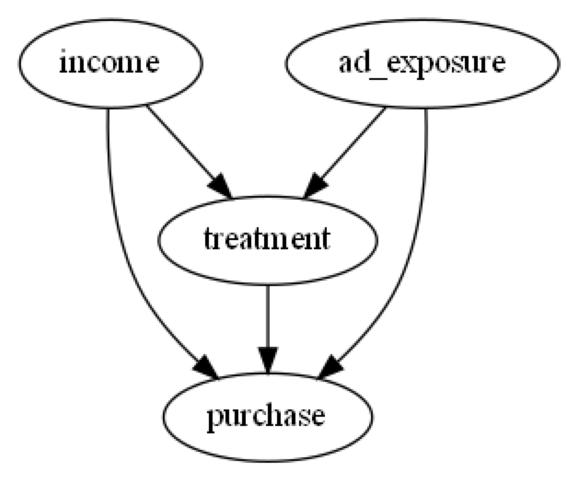

Estimated Treatment Effect:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                      
────────────(E[purchase|ad_exposure,income])
d[treatment]                                
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→purchase then P(purchase|treatment,ad_exposure,income,U) = P(purchase|treatment,ad_exposure,income)

## Realized estimand
b: purchase~treatment+ad_exposure+income
Target units: ate

## Estimate
Mean value: 0.19133346627444403



In [4]:
# Define the causal graph
causal_graph = """
digraph {
    income -> treatment;
    ad_exposure -> treatment;
    treatment -> purchase;
    income -> purchase;
    ad_exposure -> purchase;
}
"""

# Create the DoWhy model
model = CausalModel(
    data=df,
    treatment='treatment',
    outcome='purchase',
    graph=causal_graph
)

# 1. Estimate the Average Treatment Effect (ATE)
model.view_model()  # Visualize the causal graph
identified_estimand = model.identify_effect()

# Estimate the effect using a linear regression model
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

# Display the estimated treatment effect
print("Estimated Treatment Effect:")
print(causal_estimate)


#### Output Interpretation

<b>ATE=E[Y(1)]−E[Y(0)]</b> <br>

Where:<br>
E[Y(1)] is the expected outcome (e.g., purchase) for the treated group.<br>
E[Y(0)] is the expected outcome (e.g., purchase) for the non-treated group.<br>

On average, treated customers are 20.286% more likely to make a purchase than non-treated customers.

### <font color='Blue'>4. Perform Refutation Tests</font>

In [5]:
## (a) Refutation 1: Randomize treatment (Shuffling the treatment)
refuted_model_1 = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="random_common_cause",
    num_simulations=5
)
print("\nRefutation 1 - Randomizing Treatment:")
print(refuted_model_1)



Refutation 1 - Randomizing Treatment:
Refute: Add a random common cause
Estimated effect:0.19133346627444403
New effect:0.19133360565373805
p value:0.43014602991466666



#### Output Interpretation

In [6]:
## (b) Refutation 2: Adding a control for confounders (introduce another confounder)
# Here, we add a new unobserved confounder that was not initially considered
refuted_model_2 = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1
)


print("\nRefutation 2 - Adding Control for Confounders:")
print(refuted_model_2)



Refutation 2 - Adding Control for Confounders:
Refute: Add an Unobserved Common Cause
Estimated effect:0.19133346627444403
New effect:0.07314380807050691



#### Output Interpretation

### <font color='Blue'>5. Perform Placebo Test</font>

In [7]:
## Placebo Treatment: Randomly assign a fake treatment and estimate the effect
causal_estimate_placebo = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="placebo_treatment_refuter", 
    placebo_type="permute",
    num_simulations=3
)


# Display the placebo treatment estimate
print("\nPlacebo Treatment Estimate:")
print(causal_estimate_placebo)



Placebo Treatment Estimate:
Refute: Use a Placebo Treatment
Estimated effect:0.19133346627444403
New effect:0.00015831523062163436
p value:0.4470574865717978



#### Output Interpretation

The placebo treatment should ideally show no significant causal effect. If it does, that indicates a problem with the causal setup, and the observed treatment effect might be spurious.

New effect=0.0035: Indicates, Treatment effect is causal and if treatment effect is replaced with placebo then ATE(Average Treatement Effect) will be 0.35% between treated and non-treated(or No Effect)